# Writing K-Means Algorithm from Scratch using numpy
This notebook shows how we can code K-means algorithm from scratch using numpy. We start with loading some useful libraries and using blobs dataset from sklearn to create our training dataset

In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
X, y = datasets.make_blobs(n_samples=800, n_features=2, centers=3)
X.shape, y.shape

((800, 2), (800,))

In [3]:
df = pd.DataFrame(
    np.array([np.arange(800), X[:, 0], X[:, 1], y]).transpose(),
    columns=["ID", "x", "y", "cluster"],
)
df.shape

(800, 4)

## Visualizing clusters in 2-Dimensions
We will use matplotlib to plot all the points on a 2D plane and use cluster labels to separate the data points and check if using such an algorithm would give accurate results. The clusters look well separated, let us try to initiate centroids and apply K-means algorithm to this dataset

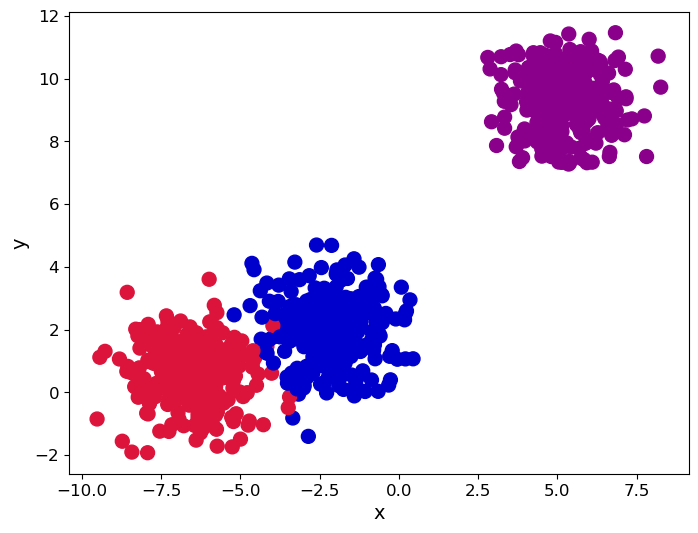

In [4]:
custommap = ListedColormap(["crimson", "mediumblue", "darkmagenta"])

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    x=df["x"], y=df["y"], s=100, c=df["cluster"].astype("category"), cmap=custommap
)
ax.set_xlabel(r"x", fontsize=14)
ax.set_ylabel(r"y", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Step 1 & 2: Define initiate centroid function and initiate centroids using k=3

In [5]:
def initiate_centroids(k, df):
    centroids = df.sample(k)
    return centroids


X = df[["x", "y"]]
y = df["cluster"]

centroids = initiate_centroids(3, X)
centroids

,x,y
86,-1.739247,2.958683
612,4.194085,9.652732
412,-5.751948,-1.172771


## Step 3 & 4: Calculate distance and Assign Centroids
In this step, we define a eucleadean distance calculator function and calculate the distance of each datapoint from above initiate centroids. We then find the minimum distance centroid, store the results in a list along with the error value for each observation iteratively. We will use total error as means of convergence.

In [6]:
def eucledean_distance(a, b):
    distance = np.sqrt(np.sum((a - b) ** 2))
    return distance


def assign_centroids(df, centroids):
    k = centroids.shape[0]
    n = df.shape[0]

    assignment = []
    assign_errors = []

    for obs in range(n):
        all_errors = np.array([])
        for centroid in range(k):
            err = eucledean_distance(centroids.iloc[centroid, :], df.iloc[obs, :])
            all_errors = np.append(all_errors, err)

        # get the nearest centroids for each observation
        nearest_centroid = np.where(all_errors == np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # storing the results
        assignment = np.append(assignment, nearest_centroid)
        assign_errors = np.append(assign_errors, nearest_centroid_error)

    return assignment, assign_errors


df["centroid"], df["error"] = assign_centroids(df, centroids)

In [7]:
df.head()

,ID,x,y,cluster,centroid,error
0,0.0,-1.778991,2.280733,1.0,0.0,0.679114
1,1.0,4.611666,9.334431,2.0,1.0,0.525061
2,2.0,3.638254,9.506182,2.0,1.0,0.574825
3,3.0,-6.250744,0.913346,0.0,2.0,2.144920
4,4.0,-7.381741,0.888740,0.0,2.0,2.627937


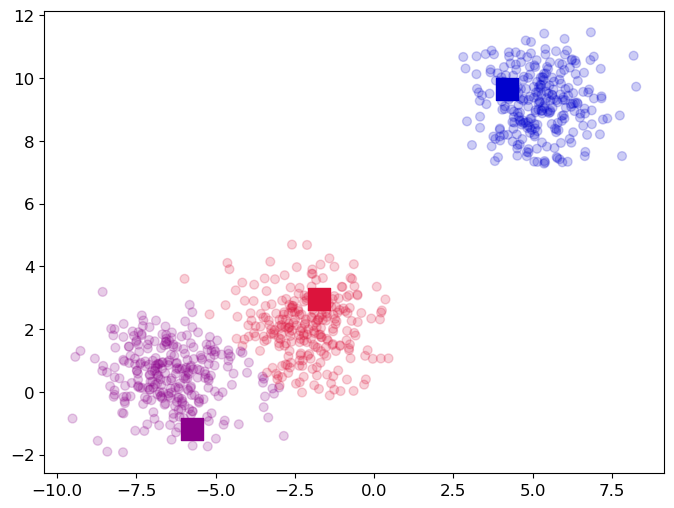

In [8]:
fig, x = plt.subplots(figsize=(8, 6))
plt.scatter(
    x=df["x"],
    y=df["y"],
    s=40,
    marker="o",
    c=df["centroid"].astype("category"),
    cmap=custommap,
    alpha=0.2,
)
plt.scatter(
    x=centroids["x"], y=centroids["y"], s=250, marker="s", c=[0, 1, 2], cmap=custommap
)
ax.set_xlabel(r"x", fontsize=14)
ax.set_ylabel(r"y", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [9]:
print(f"Total error of cluster assignment is {df['error'].sum()}")

Total error of cluster assignment is 1427.351537760421


## Step 5: Update Centroids
Let us update the location of centroids by taking mean of all the observations assigned to the centroid and re-visualize their positions in the graph

In [10]:
centroids = df.groupby("centroid").agg({"x": "mean", "y": "mean"})
centroids

,x,y
centroid,,
0.0,-2.141160,2.093468
1.0,5.191072,9.238569
2.0,-6.387744,0.522647


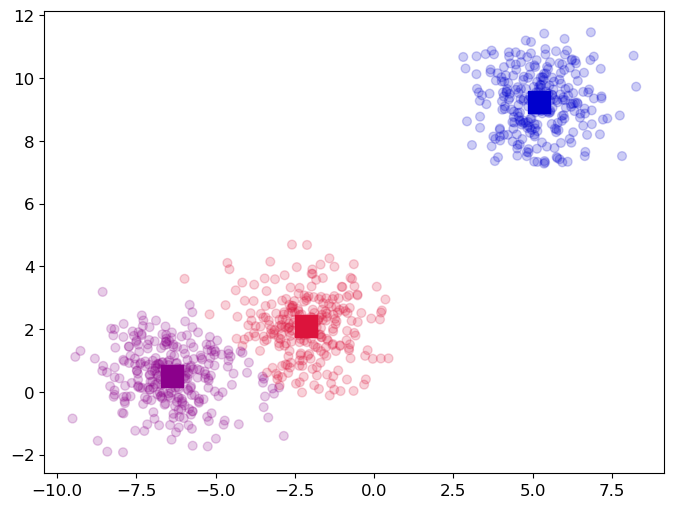

In [11]:
fig, x = plt.subplots(figsize=(8, 6))
plt.scatter(
    x=df["x"],
    y=df["y"],
    s=40,
    marker="o",
    c=df["centroid"].astype("category"),
    cmap=custommap,
    alpha=0.2,
)
plt.scatter(
    x=centroids["x"], y=centroids["y"], s=250, marker="s", c=[0, 1, 2], cmap=custommap
)
ax.set_xlabel(r"x", fontsize=14)
ax.set_ylabel(r"y", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Keeping everything in a loop and terminating the loop based on threshold value for information gain.

In [12]:
def kmeans(df, k=3, tol=1e-4):
    # initiate centroids
    X = df[["x", "y"]]
    y = df["cluster"]
    centroids = initiate_centroids(k, X)

    goahead = True
    total_error = []
    epoch = 0

    while goahead:
        # assign centroids
        df["centroid"], df["error"] = assign_centroids(df, centroids)
        # update centroids
        centroids = df.groupby("centroid").agg({"x": "mean", "y": "mean"})
        total_error.append(df["error"].sum())

        if epoch > 0:
            if np.abs(total_error[epoch - 1] - total_error[epoch]) <= tol:
                goahead = False

        epoch = epoch + 1

    df["centroid"], df["error"] = assign_centroids(df, centroids)
    centroids = df.groupby("centroid").agg({"x": "mean", "y": "mean"})
    return df["centroid"], df["error"], centroids

In [13]:
df["centroid"], df["error"], centroids = kmeans(df)

## Final Results
It took 5.7 seconds for the algorithm to converge on a 1000 datapoint dataset and below graph shows the final location of centroids along with assigned clusters. The assignment is close to our original label with some error.

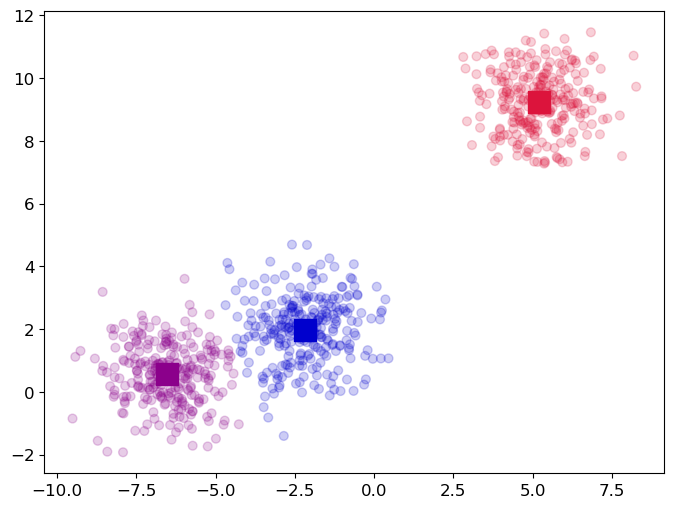

In [14]:
fig, x = plt.subplots(figsize=(8, 6))
plt.scatter(
    x=df["x"],
    y=df["y"],
    s=40,
    marker="o",
    c=df["centroid"].astype("category"),
    cmap=custommap,
    alpha=0.2,
)
plt.scatter(
    x=centroids["x"], y=centroids["y"], s=250, marker="s", c=[0, 1, 2], cmap=custommap
)
ax.set_xlabel(r"x", fontsize=14)
ax.set_ylabel(r"y", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [15]:
centroids

,x,y
centroid,,
0.0,5.191072,9.238569
1.0,-2.187258,1.988192
2.0,-6.534004,0.559452


In [16]:
print(f"Total Error for the centroids = {df['error'].sum()}")

Total Error for the centroids = 1020.1589409906819


## Elbow Rule:
We can now apply elbow rule to show that 3 is the optimal cluster size for this dataset

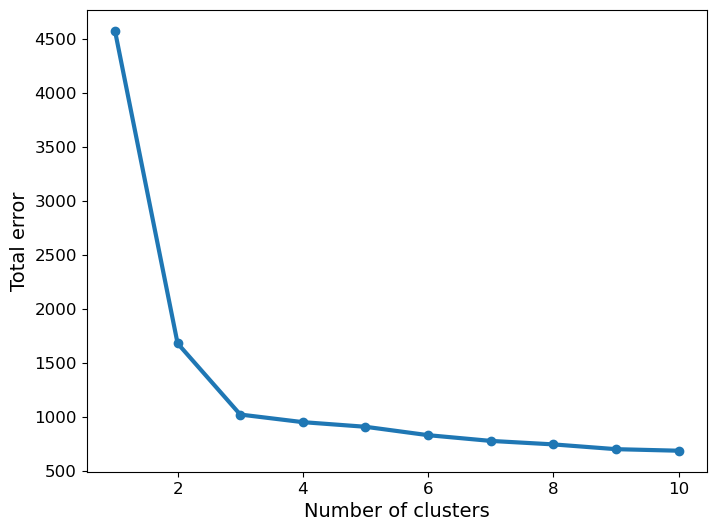

In [17]:
error = []
n = 10

df_elbow = df.copy()

for i in range(n):
    _, errs, _ = kmeans(df_elbow, k=i + 1)
    error.append(sum(errs))

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1, n + 1), error, linewidth=3, marker="o")
ax.set_xlabel(r"Number of clusters", fontsize=14)
ax.set_ylabel(r"Total error", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()